## HM4 Usage Tutorial

This notebook provides an example of how to use the Hybrid Model for Mineral Mapping on Mars (HM4) for pixel classification of a CRISM image.

In [1]:
from n2n4m.crism_image import CRISMImage
from n2n4m.plot import Visualiser, InteractiveVisualiser
from n2n4m.n2n4m_denoise import clip_bands
from n2n4m.preprocessing import impute_bad_values_in_image
from n2n4m.wavelengths import PLEBANI_WAVELENGTHS, ALL_WAVELENGTHS
from n2n4m.type_spectra import (
    CRISM_diagnostic_mineral_features,
    get_type_spectra,
    clip_type_spectra,
    get_type_spectra_name,
    get_type_spectra_class,
)

from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hm4.labelling import CLASS_NAMES, PLATT_TO_PLEBANI
from hm4.VAE_classifier_248 import VAEClassifier
from hm4.plot import convert_to_coords_filter_regions_by_conf, mineral_colours

First load an image. This must have had the standard atmospheric and photometric corretions, as well as the "Volcano-Scan" correction applied. These corrections can be applied through the CAT ENVI/IDL extension, or through the MarsSI web-gis tool. The image must be in a .img format.  

The CRISM_ML [1] bland dataset must also be downloaded from https://zenodo.org/records/13338091 to allow for ratioing of pixels as a preprocessing step.

[1] Plebani, E., Ehlmann, B. L., Leask, E. K., Fox, V. K., & Dundar, M. M.
(2022). A machine learning toolkit for CRISM image analysis.
Icarus, 376, 114849. https://doi.org/10.1016/j.icarus.2021.114849

In [ ]:
IMAGE_FILEPATH = # insert filepath here
CRISM_ML_DIR = # insert the path to the PARENT directory of the CRISM_ML data .mat file
MODEL_WEIGHTS_PATH = # insert the path to the HM4 model weights .pth file

In [ ]:
image = CRISMImage(IMAGE_FILEPATH)

Image loaded successfully.


Next we will ratio the image as a preprocessing step, and calculate some standard summary parameters for visualisation purposes.

In [ ]:
# This may take a few minutes the first time you run it
image.ratio_image(CRISM_ML_DIR)
image.calculate_summary_parameter("CINDEX2")
image.calculate_summary_parameter("hyd_femg_clay_index")
image.calculate_summary_parameter("LCPINDEX2")
image.calculate_summary_parameter("HCPINDEX2")

/scratch_dgxl/rp1818/HM4/.venv/lib/python3.11/site-packages/n2n4m/preprocessing.py:263: RuntimeWarning: Mean of empty slice
  image_copy = np.nan_to_num(image_copy, nan=np.nanmean(image_copy, axis=0))
/scratch_dgxl/rp1818/HM4/.venv/lib/python3.11/site-packages/crism_ml/preprocessing.py:409: RuntimeWarning: invalid value encountered in divide
  normed = pixspec[idx, :, :] / bland
/scratch_dgxl/rp1818/HM4/.venv/lib/python3.11/site-packages/n2n4m/summary_parameters.py:147: RuntimeWarning: invalid value encountered in divide
  band_depth = center_ref / interpolated_center_ref
/scratch_dgxl/rp1818/HM4/.venv/lib/python3.11/site-packages/n2n4m/summary_parameters.py:230: RuntimeWarning: invalid value encountered in divide
  relative_band_depth = (


/scratch_dgxl/rp1818/HM4/.venv/lib/python3.11/site-packages/n2n4m/plot.py:105: UserWarning: Bad values detected in the image. A copy has been made, values > 1000 will be replaced with np.nan.
  warnings.warn(


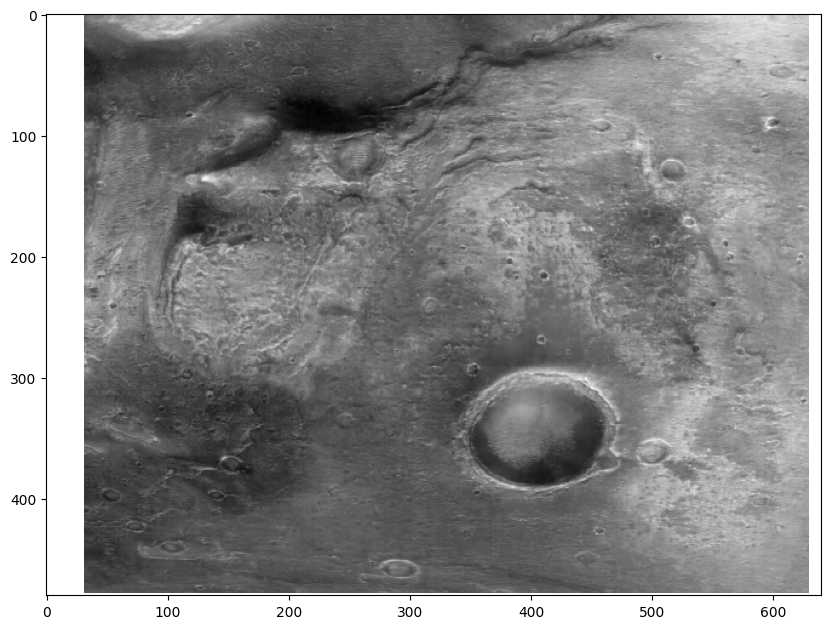

In [4]:
# Lets have a look at the image
static_vis = Visualiser(image)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

In [5]:
# Use this to have an interactive plot of the image, and be able to look at spectra
# and summary parameters
vis = InteractiveVisualiser(image)
vis.interactive_plot()

Now do some preprocessing for the HM4 model.

In [6]:
# First extract the ratioed image
ratioed_im = image.ratioed_image
# Flatten the image into a array of spectra
im_shape = image.im_shape
ratioed_im = ratioed_im.reshape(-1, 438)  # 438 bands
# Drop from the 438 CRISM bands to the 350 given in [1]
# and then drop to the 248 used in [1], [2], and here for ML
ratioed_im, _ = clip_bands(ratioed_im)
ratioed_im = ratioed_im[:, :248]  # 248 bands to use for the model
# Impute any bad values, using a hierarchical approach
ratioed_im, _ = impute_bad_values_in_image(ratioed_im, threshold=10)
# Normalise the values to between 0 and 1.
# Keep the min and max vals for the inverse operation later.
ratioed_im = torch.tensor(ratioed_im.astype(np.float32))
min_vals = torch.min(ratioed_im, dim=-1, keepdim=True).values
max_vals = torch.max(ratioed_im, dim=-1, keepdim=True).values
ratioed_im_scaled = (ratioed_im - min_vals) / ((max_vals - min_vals) + 0.00001)
# Wrap the data into a nice format for the model
data_loader = DataLoader(ratioed_im_scaled, batch_size=256, shuffle=False)

In [ ]:
# Instantiate the model, and load the weights from the weights .pth file
# For simplicity, running inference on CPU as the model is very small.
model = VAEClassifier(
    n_blocks=1, n_conv_layers=1, zx_dim=16, zy_dim=16, n_classes=38
)
model.load_state_dict(
    torch.load(MODEL_WEIGHTS_PATH, map_location=torch.device("cpu"))
)

<All keys matched successfully>

Now run the model. Collect both the classification outputs and the spectra reconstructions.

In [8]:
y_pred_list = []
x_recon_arr = []
for x in data_loader:
    x_recon, y_pred = model.reconstruct_classify(x.unsqueeze(1))
    y_pred_list.append(y_pred.detach().numpy())
    x_recon_arr.append(x_recon.detach().numpy())
# The prediction probabilities are useful later for confidence assessment
y_pred_probs = torch.tensor(np.concatenate(y_pred_list, axis=0))
# The highest probability class per pixel is the predicted mineral y_pred
y_pred = torch.argmax(y_pred_probs, axis=1)
x_recon = torch.tensor(np.concatenate(x_recon_arr, axis=0)).reshape(-1, 248)

In [9]:
# inverse transform the spectral reconstructions back to I/F reflectance values
x_recon = x_recon * (max_vals - min_vals) + min_vals
# reshape the reconstructions back to the shape of the image.
x_recon = x_recon.detach().numpy().reshape((*im_shape[:2], 248))

Text(0.5, 1.0, 'Violin plot of Classification Confidence')

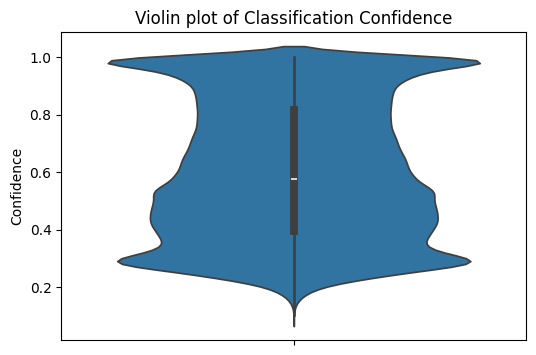

In [10]:
# Plot the model confidence distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(y=y_pred_probs.max(dim=1)[0], ax=ax)
ax.set_ylabel("Confidence")
ax.set_title("Violin plot of Classification Confidence")

In [11]:
# reshape the class predictions ot the shape of the image
y_pred_im = y_pred.reshape(im_shape[:2])
# the confidence scores are the models prediction probability in the predicted class
confidence_scores = y_pred_probs.max(dim=1)[0].reshape(im_shape[:2]).squeeze(1)

Any bad values in the input image (0 < value < 1000) were imputed before running the model. Relying on imputed values for classification can be innaccurate, so will filter out any pixel predictions which involved a significant (>15%) amount of imputation.

In [12]:
wavelength_mask = np.isin(ALL_WAVELENGTHS, PLEBANI_WAVELENGTHS)
bad_pix_mask = image.bad_pix_mask[:, :, wavelength_mask][:, :, :248]
bad_pix_filter = bad_pix_mask.sum(axis=2) > 38
# Accomplishing the filtering by replacing the class label of any bad pixels with a non-existant class. This way they don't mess with the
# confidence and area filtering
y_pred_im_filtered = np.where(bad_pix_filter, -1, y_pred_im)

Lets plot the mineral predictions

In [13]:
all_pred_coords = convert_to_coords_filter_regions_by_conf(
    y_pred_im_filtered, confidence_scores, min_area=0, min_confidence=0.0
)
all_pred_coords = {
    k: v
    for k, v in sorted(
        all_pred_coords.items(), key=lambda item: len(item[1]), reverse=True
    )
}

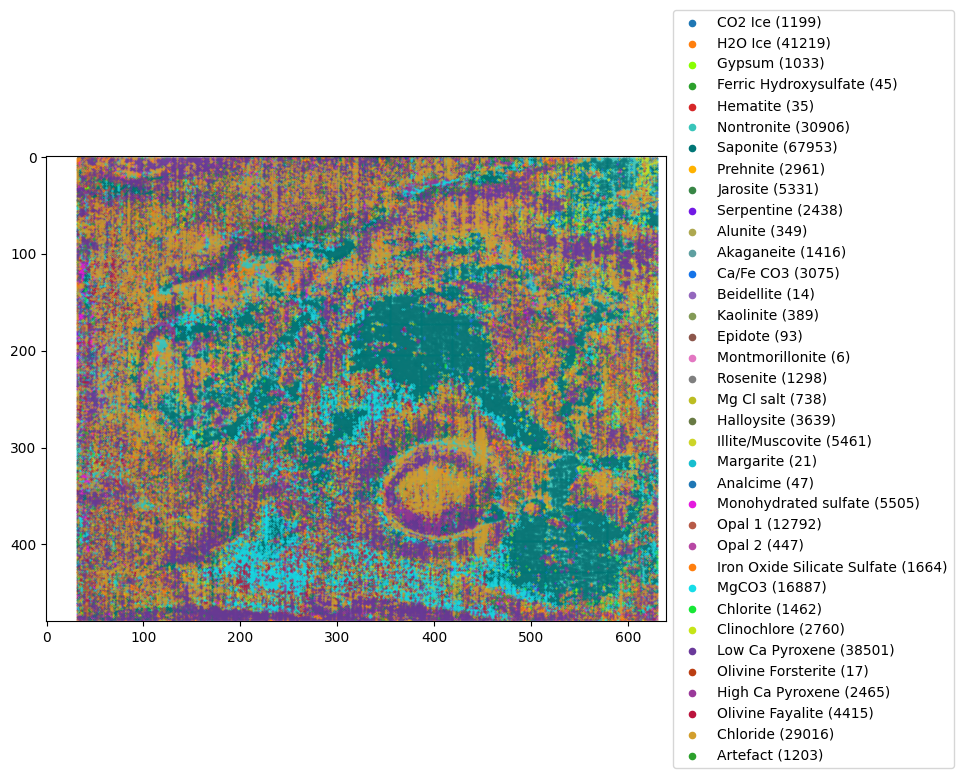

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")
for i, (pred_class, coords) in enumerate(all_pred_coords.items()):
    if pred_class == -1:
        continue
    if len(coords) > 1:
        try:
            ax.scatter(
                coords[0],
                coords[1],
                s=0.1,
                color=mineral_colours[CLASS_NAMES[pred_class]],
                label=f"{CLASS_NAMES[pred_class]} ({len(coords[0])})",
            )
        except KeyError:
            ax.scatter(
                coords[0],
                coords[1],
                s=0.1,
                label=f"{CLASS_NAMES[pred_class]} ({len(coords[0])})",
            )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

The above looks fairly kalaidoscopic and contains a lot of noise. Filtering the results by a minimum size component, and a minimum prediction confidence, allows for more useful visualisation

In [15]:
pred_coords_bad_val_filtered = convert_to_coords_filter_regions_by_conf(
    y_pred_im_filtered, confidence_scores, min_area=10, min_confidence=0.75
)
pred_coords_bad_val_filtered = {
    k: v
    for k, v in sorted(
        pred_coords_bad_val_filtered.items(),
        key=lambda item: len(item[1]),
        reverse=True,
    )
}

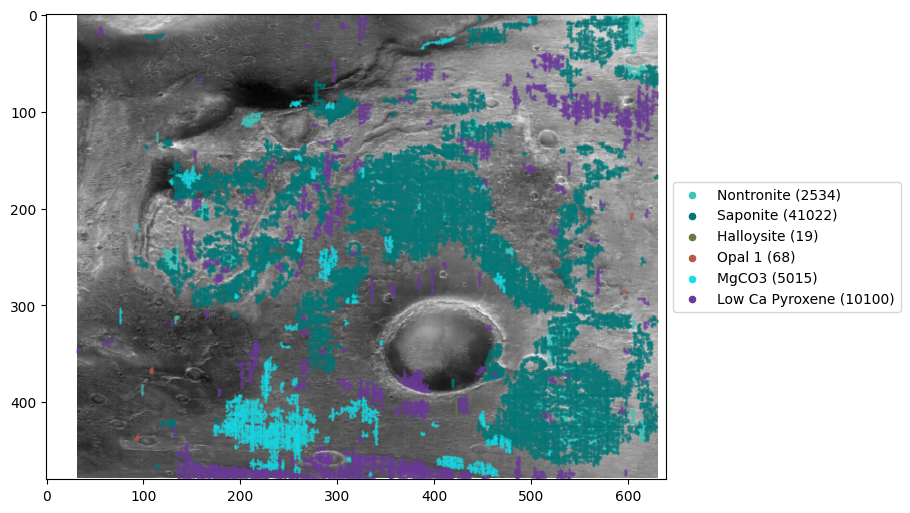

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")
for i, (pred_class, coords) in enumerate(pred_coords_bad_val_filtered.items()):
    if pred_class == 1 or pred_class == 0:  # skip ices
        continue
    if len(coords) > 1:
        try:
            ax.scatter(
                coords[0],
                coords[1],
                s=0.1,
                color=mineral_colours[CLASS_NAMES[pred_class]],
                label=f"{CLASS_NAMES[pred_class]} ({len(coords[0])})",
            )
        except KeyError:
            ax.scatter(
                coords[0],
                coords[1],
                s=0.1,
                label=f"{CLASS_NAMES[pred_class]} ({len(coords[0])})",
            )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

This is a much more useful plot.

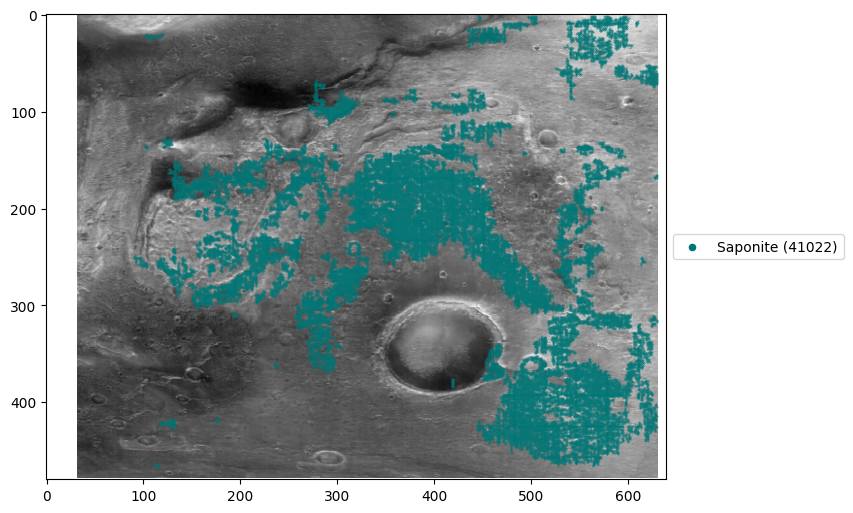

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

class_number = 6  # Change this to whichever mineral you wish to plot. The mineral names and their corresponding class numbers are in CLASS_NAMES

coords = pred_coords_bad_val_filtered[class_number]
try:
    ax.scatter(
        coords[0],
        coords[1],
        s=0.1,
        color=mineral_colours[CLASS_NAMES[class_number]],
        label=f"{CLASS_NAMES[class_number]} ({len(coords[0])})",
    )
except IndexError:
    print(f"No pixels of {CLASS_NAMES[class_number]} found")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

To plot the type spectra, a local copy of the CRISM/MICA files is needed. These can be found here: https://pds-geosciences.wustl.edu/mro/mro-m-crism-4-typespec-v1/mrocr_8001/data/

In [ ]:
TYPE_SPECTRA_PATH = # insert the path to the local copy of the CRISM/MICA type spectra here
mineral_class = 6 # Change this to whichever mineral you wish to plot. The mineral names and their corresponding class numbers are in CLASS_NAMES

Text(0.5, 1.0, 'Average Saponite Spectrum')

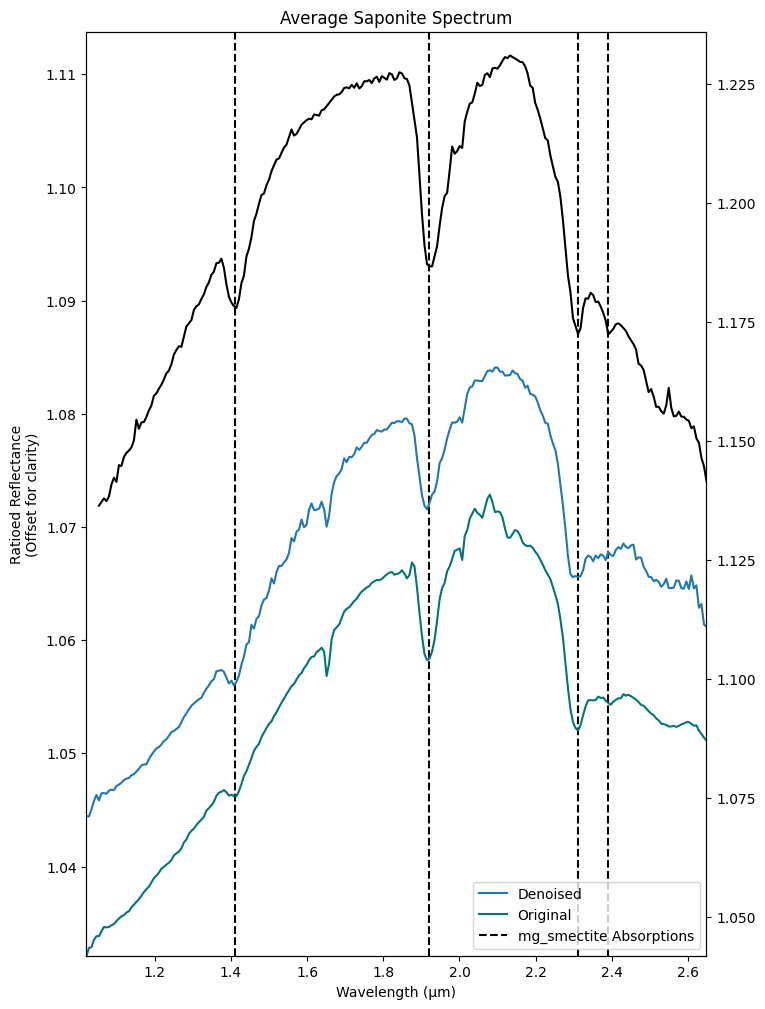

In [ ]:
# Denoised average mineral spectrum
denoised_mineral = x_recon[
    pred_coords_bad_val_filtered[mineral_class][1],
    pred_coords_bad_val_filtered[mineral_class][0],
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

# Original average mineral spectrum
original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[
    pred_coords_bad_val_filtered[mineral_class][1],
    pred_coords_bad_val_filtered[mineral_class][0],
]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)

# The type spectra for that mineral from the CRISM/MICA library
# Mocking up a sample using the pixel classes N2N4M uses to get the type spectra
dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[6]], *np.zeros(248)],
    index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(
    PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg + 0.01, label="Denoised"
)  # +0.01 offset for clarity
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_mineral_avg,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label="Original",
)
ax2.plot(
    type_spec_wavelengths,
    mineral_type_spec.values,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)


ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis="both", which="major")
ax.tick_params(axis="both", which="minor")

ax1_y_max = (
    denoised_mineral_avg.max() - denoised_mineral_avg.min()
) + denoised_mineral_avg.max()
ax2_y_min = mineral_type_spec.values[:248].min() - (
    mineral_type_spec.values[:248].max() - mineral_type_spec.values[:248].min()
)

# Add vertical lines for the diagnostic absorption features
type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=original_mineral_avg.min(),
    ymax=ax1_y_max,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0,
)

ax.set_ylim(original_mineral_avg.min(), ax1_y_max)
ax2.set_ylim(ax2_y_min, mineral_type_spec.values[10:220].max() + 0.005)
ax.legend(loc="lower right")
ax.set_title("Average Saponite Spectrum")

Lets have a look at a different mineral class as well

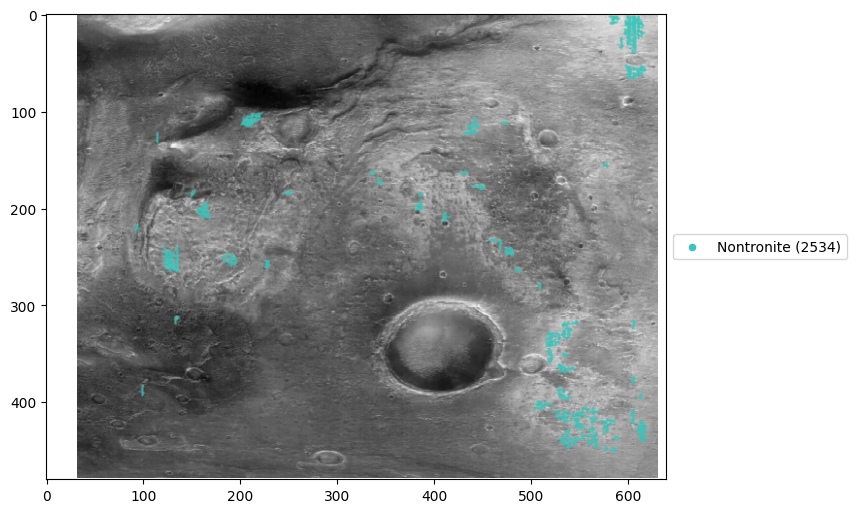

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(static_vis.get_image(60), cmap="gray")

mineral_class = 5
coords = pred_coords_bad_val_filtered[mineral_class]
ax.scatter(coords[0], coords[1], s=0.1, color=mineral_colours[CLASS_NAMES[mineral_class]], label=f"{CLASS_NAMES[mineral_class]} ({len(coords[0])})")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for handle in ax.get_legend().legend_handles:
    handle.set_sizes([20])

In [22]:
mineral_class = 5

Text(0.5, 1.0, 'Average Saponite Spectrum')

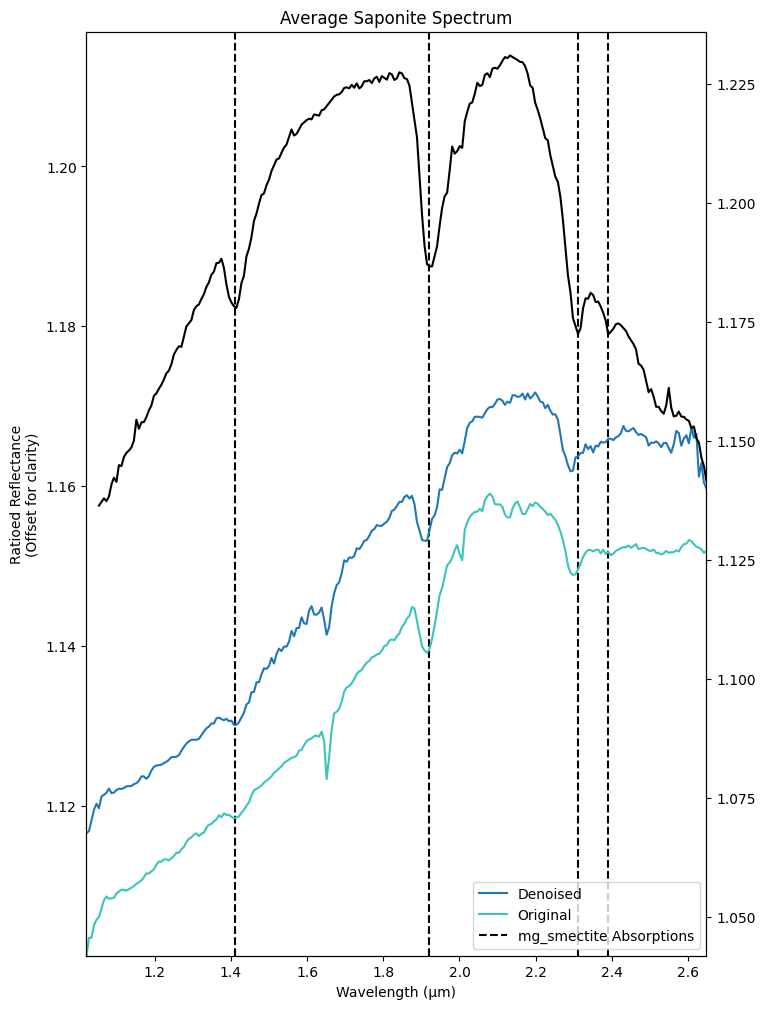

In [ ]:
# Denoised average mineral spectrum
denoised_mineral = x_recon[
    pred_coords_bad_val_filtered[mineral_class][1],
    pred_coords_bad_val_filtered[mineral_class][0],
]
denoised_mineral = denoised_mineral.reshape(-1, 248)
denoised_mineral_avg = np.average(denoised_mineral, axis=0)

# Original average mineral spectrum
original_mineral = ratioed_im.reshape((*im_shape[:2], 248))[
    pred_coords_bad_val_filtered[mineral_class][1],
    pred_coords_bad_val_filtered[mineral_class][0],
]
original_mineral = original_mineral.reshape(-1, 248)
original_mineral_avg = np.average(original_mineral, axis=0)

# The type spectra for that mineral from the CRISM/MICA library
# Mocking up a sample using the pixel classes N2N4M uses to get the type spectra
dummy_sample = pd.Series(
    [[PLATT_TO_PLEBANI[6]], *np.zeros(248)],
    index=["Pixel_Class", *[str(x) for x in PLEBANI_WAVELENGTHS[:248]]],
)
mineral_type_spec = get_type_spectra(
    dummy_sample, TYPE_SPECTRA_PATH
)
mineral_type_spec = clip_type_spectra(dummy_sample, mineral_type_spec)
type_spec_wavelengths = [float(x) for x in mineral_type_spec.index]

fig, ax = plt.subplots(figsize=(8, 12))

ax2 = ax.twinx()
ax.plot(
    PLEBANI_WAVELENGTHS[:248], denoised_mineral_avg + 0.01, label="Denoised"
)  # +0.01 offset for clarity
ax.plot(
    PLEBANI_WAVELENGTHS[:248],
    original_mineral_avg,
    c=mineral_colours[CLASS_NAMES[mineral_class]],
    label="Original",
)
ax2.plot(
    type_spec_wavelengths,
    mineral_type_spec.values,
    c="black",
    label=f"{get_type_spectra_name(dummy_sample)} Type Spectrum",
)


ax.set_xlabel("Wavelength (μm)")
ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)")
ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
ax.tick_params(axis="both", which="major")
ax.tick_params(axis="both", which="minor")

ax1_y_max = (
    denoised_mineral_avg.max() - denoised_mineral_avg.min()
) + denoised_mineral_avg.max()
ax2_y_min = mineral_type_spec.values[:248].min() - (
    mineral_type_spec.values[:248].max() - mineral_type_spec.values[:248].min()
)

# Add vertical lines for the diagnostic absorption features
type_spectra_class = get_type_spectra_class(dummy_sample)
absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
absorption_feats = [x for x in absorption_feats if x < 2.6]
ax.vlines(
    absorption_feats,
    ymin=original_mineral_avg.min(),
    ymax=ax1_y_max,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"{type_spectra_class} Absorptions",
    zorder=0,
)

ax.set_ylim(original_mineral_avg.min(), ax1_y_max)
ax2.set_ylim(ax2_y_min, mineral_type_spec.values[:248].max() + 0.005)
ax.legend(loc="lower right")
ax.set_title("Average Saponite Spectrum")

Finally we can save the class predictions and reconstructions out to a new .img file to be used in ENVI or GIS software.

In [24]:
pred_im_filtered = np.full_like(y_pred_im, 65535.0)
for pred_class, coords in pred_coords_bad_val_filtered.items():
    if len(coords) > 0:
        pred_im_filtered[coords[1], coords[0]] = pred_class

In [25]:
denoised_ratioed_im = np.zeros((image.im_shape))
denoised_ratioed_im[:, :, :248] = x_recon
denoised_ratioed_im[:, :, 248:] = image.ratioed_image[:, :, 248:]

In [26]:
denoised_ratioed_im[np.isnan(denoised_ratioed_im)] = 65535.0
denoised_ratioed_im[denoised_ratioed_im < 0] = 65535.0
denoised_ratioed_im[denoised_ratioed_im > 5] = 65535.0

In [27]:
# The last two bands are the mineral class and confidence score
denoised_ratioed_im[:, :, -2] = pred_im_filtered
denoised_ratioed_im[:, :, -1] = confidence_scores

In [28]:
denoised_ratioed_im = denoised_ratioed_im.astype("float32")

In [ ]:
# Write out the new image. This must be a .hdr file WITH THE SAME NAME AS THE ORIGINAL .hdr file, for the metadata to be read correctly in ENVI.
# To avoid overwriting the original image, save to a different directory.
output_filepath = # insert filepath here
image.write_image(output_filepath, denoised_ratioed_im, reverse_bands=True)